# Buffering data

In some analysis it is necessary to find the influence of a feature in the surrounding areas, in this situation the `buffer` operation will help.

To create buffers, first add the `geopandas` package.

In [474]:
from pathlib import Path
import geopandas as gp
base_path = Path.cwd().parents[0]
INPUT = base_path / "00_data"
OUTPUT = base_path / "out"

The input data is then loaded:

In [475]:
input_layer = gp.read_file(OUTPUT / "clipped.shp")[5:8]

`````{admonition}  
:class: danger
Since the input layer will be modified by the buffer operation, a copy of the input layer will be created.
`````


In [476]:
buffer_layer = input_layer.copy()

## Non-Overlapping Buffers

Using the `buffer` method, buffers are created by modifying the geometry of the input layer. The value defined within the buffer method is the size of the buffer and its unit depends on the coordinate system of the layer.

```{admonition} **Example of Units**
:class: note, dropdown
- WGS 84 (EPSG Code:4326): **Degrees**.
- ETRS89 / UTM Zone 32N (EPSG Code:25832): **Meters**.
```

In [477]:
buffer_layer['geometry'] = buffer_layer['geometry'].buffer(5)

The original layer and the result of the buffer is visualized using the parameters in the `plot` function: 
- `ax`: Overlays multiple plots on a map.
- `alpha`: Controls the transparency of the layers for better visualization. (ranges from 1 to 0 (fully transparent)) 

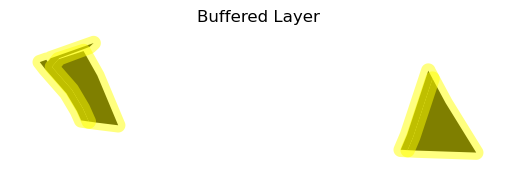

In [478]:
ax = input_layer.plot(color='black', alpha=1)
buffer_layer.plot(ax=ax, color='yellow', alpha=0.5)
ax.set_title("Buffered Layer")
ax.set_axis_off()

The geometry column can be checked both before and after the `buffer` operation to observe the changes.

In [479]:
input_layer.head(3)

,KS_IS,CLC_st1,CLC18,CLC,Biotpkt201,Shape_Leng,Shape_Area,geometry
5,None,122,122,122.0,5.271487,346.752729,5474.275433,"POLYGON ((403395.292 5657959.434, 403395.356 5..."
6,None,324,324,324.0,14.000424,429.176933,3932.817729,"POLYGON ((403167.254 5657979.347, 403167.22 56..."
7,HW,122,None,NaN,5.271487,1096.631901,2365.341424,"MULTIPOLYGON (((403167.35 5658020.068, 403167...."


In [480]:
buffer_layer.head(3)

,KS_IS,CLC_st1,CLC18,CLC,Biotpkt201,Shape_Leng,Shape_Area,geometry
5,None,122,122,122.0,5.271487,346.752729,5474.275433,"POLYGON ((403390.644 5657961.28, 403400.031 56..."
6,None,324,324,324.0,14.000424,429.176933,3932.817729,"POLYGON ((403155.533 5657989.329, 403142.122 5..."
7,HW,122,None,NaN,5.271487,1096.631901,2365.341424,"MULTIPOLYGON (((403386.428 5657962.864, 403395..."


## Overlapping Buffers

When the layers are printed after `buffer` operation, the number of features remains the same. This indicates the buffer operation creates an individual buffer for each feature, rather than merging overlapping areas.

In [481]:
input_layer.shape

(3, 8)

In [482]:
buffer_layer.shape

(3, 8)

The `dissolve` function can merge all the buffers at once, creates a single feature from the whole dataset:

In [483]:
dissolved_buffer = buffer_layer.dissolve()
dissolved_buffer

,geometry,KS_IS,CLC_st1,CLC18,CLC,Biotpkt201,Shape_Leng,Shape_Area
0,"MULTIPOLYGON (((403421.977 5657985.634, 403421...",HW,122,122,122.0,5.271487,346.752729,5474.275433


If `only` the merging of `overlapping buffers` is required, the overlapping areas need to be identified first. 

This can be done by overlaying the layer with itself to find the areas where the buffers intersect:

```{admonition} 
:class: note
- By using `how='inner'`, only the intersecting features will be included in the output.
```

In [484]:
overlapping_buffers = gp.sjoin(
    buffer_layer, 
    buffer_layer[['CLC18','geometry']], 
    how="inner", 
    predicate="intersects")
overlapping_buffers.head(5)

,KS_IS,CLC_st1,CLC18_left,CLC,Biotpkt201,Shape_Leng,Shape_Area,geometry,index_right,CLC18_right
5,None,122,122,122.0,5.271487,346.752729,5474.275433,"POLYGON ((403390.644 5657961.28, 403400.031 56...",5,122
5,None,122,122,122.0,5.271487,346.752729,5474.275433,"POLYGON ((403390.644 5657961.28, 403400.031 56...",7,None
6,None,324,324,324.0,14.000424,429.176933,3932.817729,"POLYGON ((403155.533 5657989.329, 403142.122 5...",7,None
6,None,324,324,324.0,14.000424,429.176933,3932.817729,"POLYGON ((403155.533 5657989.329, 403142.122 5...",6,324
7,HW,122,None,NaN,5.271487,1096.631901,2365.341424,"MULTIPOLYGON (((403386.428 5657962.864, 403395...",5,122


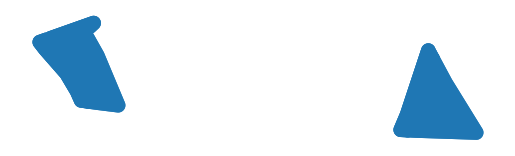

In [485]:
ax = overlapping_buffers.plot()
ax.set_axis_off()

Then the `dissolve` operation is performed to merge **only the overlapping buffers**.

In [486]:
dissolving_buffer = overlapping_buffers.dissolve()
dissolving_buffer

,geometry,KS_IS,CLC_st1,CLC18_left,CLC,Biotpkt201,Shape_Leng,Shape_Area,index_right,CLC18_right
0,"MULTIPOLYGON (((403421.977 5657985.634, 403421...",HW,122,122,122.0,5.271487,346.752729,5474.275433,5,122


```{admonition} **Buffer Parameters**
:class: tip, dropdown
In addition to the `distance` parameter, which indicates the size of the buffer, there are other parameters that help in processing and visualizing the output. 

`resolution` is a parameter that defines the number of segments used to create a quarter circle. The larger values for this parameter cause slower processing.

`cap_style`defines the shape of the end of the buffer, which is mostly used for line features. 
- cap_style = **1** defines **Round** shape.
- cap_style = **2** defines **Flat** shape.
- cap_style = **3** defines **Square** shape.

`join_style` defines the shape of the corner and edges in the buffers.
- join_style = **1** defines **Round** shape.
- join_style = **2** defines **Mitre** shape.
- join_style = **3** defines **Bevel** shape.
```

```{figure} https://geopandas.org/en/stable/_images/buffer.png
:height: 500px
:name: figure-example

Visualization of Buffer Parameters (Source: [GeoPandas website](https://geopandas.org/en/stable/_images/buffer.png)).
```

In [487]:
input_layer = gp.read_file(OUTPUT / "clipped.shp")[:1]
buffer_layer = input_layer.copy()

The following code creates a buffer of:
- 20 (The unit depends on the CRS),
- with a resolution of 8,
- round ends,
- and beveled corners.

In [488]:
buffer_layer['geometry'] = input_layer['geometry'].buffer(
    distance=20, 
    resolution=8, 
    cap_style=2, 
    join_style=3)

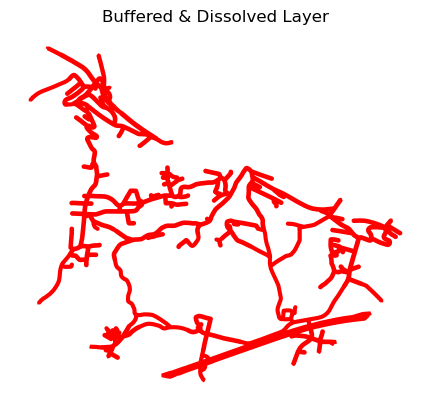

In [489]:
ax = buffer_layer.plot(color='red')
ax.set_title("Buffered & Dissolved Layer")
ax.set_axis_off()

## Negative Buffers

Sometimes a feature is so large that it affects the analysis. In such cases, a negative buffer is defined to reduce the impact of the feature itself.

The desired feature or dataset is loaded first.

In [490]:
First_layer = gp.read_file(OUTPUT / "clipped.shp")[1:2]
copy_layer = First_layer.copy()

In this case, simply define a negative value for the `distance` parameter, instead of a positive value.

In [491]:
copy_layer['geometry'] = copy_layer['geometry'].buffer(distance= -4) 

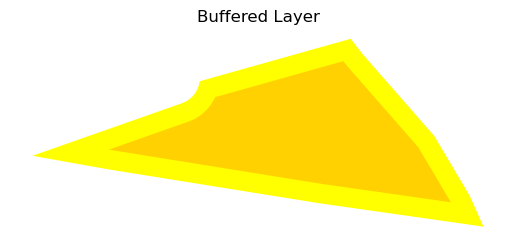

In [492]:
ax = First_layer.plot(color='yellow', alpha=1)
copy_layer.plot(ax=ax, color='orange', alpha=0.5)
ax.set_title("Buffered Layer")
ax.set_axis_off()

## Multi-Ring Buffers

To analyze the effect of a feature at different distances, it can be helpful to create concentric buffer zones (multi-ring buffers) around the feature.

As these buffers needed to combine the `pandas` library should be imported. 

In [493]:
import pandas as pd

The data is loaded.

In [494]:
First_layer = gp.read_file(OUTPUT / "clipped.shp")[2:3]
copied_layer = First_layer.copy()

The buffer distances are defined as a list.

In [495]:
distances = [ -0.2, 4, 10] 

An empty list is created for containing the buffers for the defined distances.

In [496]:
buffer_data = []

A `for loop` is used to generate buffers around each feature in the dataset. 

Then both the distances and the geometry of buffers store in the empty list that already created.

In [497]:
for items in distances:
    buffered_geom = copied_layer.geometry.buffer(items)
    for geom in buffered_geom:
        buffer_data.append({'geometry': geom, 'distance': items})

Then the list converts to a GeoDataFrame.

In [498]:
buffers = gp.GeoDataFrame(buffer_data)

In [499]:
print (buffers)

                                            geometry  distance
0  POLYGON ((402993.661 5658109.321, 402994.216 5...      -0.2
1  POLYGON ((402989.932 5658106.707, 402989.542 5...       4.0
2  POLYGON ((402983.705 5658107.102, 402983.679 5...      10.0


All the buffers can then be plotted together in the same window:

First, a separate layer is created for each buffer distance by selecting the corresponding distance variable.

In [500]:
buffers_2 = buffers[buffers['distance'] == -0.2]
buffers_4 = buffers[buffers['distance'] == 4]
buffers_10 = buffers[buffers['distance'] == 10]

Then as already mentioned in this section, using the `ax` parameter the layers overlay for visualization.

Using the `Patch` function in `matplotlib`, a colored patch is created that can be used as a legend entry in a plot.

- `color`: sets the color of the patch
- `label`: specifies the lable of that color in the legend

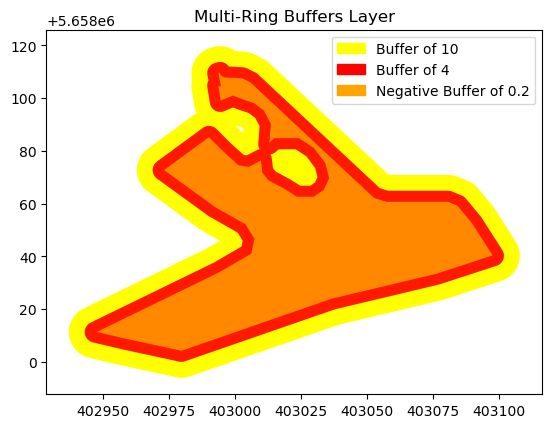

In [501]:
ax = buffers_10.plot(color='yellow', label='Buffer of 10')
buffers_4.plot(ax=ax, color='red', alpha= 0.9,label='Buffer of 4')
buffers_2.plot(ax=ax, color='orange', alpha= 0.8,label='Negative Buffer of 0.2')

#legend
import matplotlib.patches as mpatches
legend_handles = [
    mpatches.Patch(color='yellow', label='Buffer of 10'),
    mpatches.Patch(color='red', label='Buffer of 4'),
    mpatches.Patch(color='orange', label='Negative Buffer of 0.2')

]

plt.title("Multi-Ring Buffers Layer")
plt.legend(handles=legend_handles)
plt.show()

Also to be able to compare the created buffers for each feature, radio button can be helpful.

<Figure size 640x480 with 0 Axes>

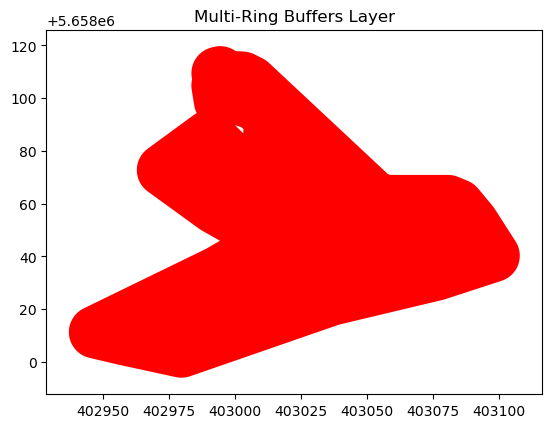

interactive(children=(RadioButtons(description='Buffer Distance', options=(10, 4, -0.2), value=10), Output()),…

In [509]:
import matplotlib.pyplot as plt
import ipywidgets as w
from ipywidgets import interactive

# Create the radio buttons widget
radiobuttons = w.RadioButtons(
    value=10,                    # Default selected value
    options=[10, 4, -0.2],       # Options for buffer distances
    description="Buffer Distance",
)

# Create the interactive plot using a lambda function
interactive_plot = interactive(
    lambda selected_distance: (
        plt.clf(),  # Clear the current plot
        (buffers_10.plot(color='red', label='Buffer of 10') if selected_distance == 10 else None),
        (buffers_4.plot(color='yellow', label='Buffer of 4') if selected_distance == 4 else None),
        (buffers_2.plot(color='orange', label='Negative Buffer of 0.2') if selected_distance == -0.2 else None),
        plt.title("Multi-Ring Buffers Layer"),
        plt.show()
    ),
    selected_distance=radiobuttons
)

# Display the interactive widget
display(interactive_plot)
